<div class="alert alert-info">
<h2> Проект </h2>


Retrieval-система по статьям с arXiv. Ерохин Виталий
</div>


<font color='red'>

In [2]:
#загрузка
%pip install -r nlp4_req.txt 

  Using cached aiohttp-3.12.15-cp311-cp311-macosx_11_0_arm64.whl.metadata (7.7 kB)
  Using cached anyio-4.10.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached backports.tarfile-1.2.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached build-1.3.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached cachecontrol-0.14.3-py3-none-any.whl.metadata (3.1 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached cffi-1.17.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (1.5 kB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-macosx_10_9_universal2.whl.metadata (35 kB)
  Using cached cleo-2.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached comm-0.2.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached crashtest-0.4.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached cryptography-45.0.5-cp311-abi3-macosx_10_9_universal2.whl.metadata (5.7 

In [1]:
%pip install langchain langchain-community langchain-core faiss-cpu

  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langgraph-1.0.4-py3-none-any.whl.metadata (7.8 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached uuid_utils-0.12.0-cp39-abi3-macosx_10_12_x86_64.macosx_11_0_arm64.macosx_10_12_universal2.whl.metadata (1.1 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached langgraph_prebuilt-1.0.5-py3-none-any.whl.metadata (5.2 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached langchain_classic-1.0.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.12.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cach

In [34]:
# 1. Импорты библиотек

from typing import List, Optional, Dict, Tuple
import os
import json
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm
import time
import gc
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import torch
from torch import Tensor
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')


In [35]:
### проверка наличия папок и файлов
import sys
from pathlib import Path

# Просмотр текущей рабочей директории
print("Текущая рабочая директория:")
print(f"os.getcwd(): {os.getcwd()}")
#print(f"Path.cwd(): {Path.cwd()}")
print()

# Просмотр содержимого текущей директории
print("Содержимое текущей директории:")
print("Файлы и папки:")
items = os.listdir()
for item in items:
    item_path = Path(item)
    if item_path.is_dir():
        print(f"📁 {item}/")
    else:
        print(f"📄 {item} ({item_path.stat().st_size} bytes)")
print()


Текущая рабочая директория:
os.getcwd(): /Users/vitaliy/myproj/sprint8/RAG_system

Содержимое текущей директории:
Файлы и папки:
📄 arxiv-metadata-s.json (231636178 bytes)
📄 .DS_Store (6148 bytes)
📄 RAG_sys_experimental.ipynb (58833 bytes)
📄 test_sample.csv (1138529 bytes)
📄 README.md (75 bytes)
📄 nlp_s3_data.zip (59848392 bytes)
📁 .git/
📄 nlp4_req.txt (2992 bytes)



In [41]:
# 2: Загрузка и анализ датасета и тестовых данных

# 2.1 загрузка arxiv-metadata-s.json, отфильтрованного по "id", "title", "categories", "abstract"

import json
import time
import sys
import os
from tqdm import tqdm

ARXIV_DATA_PATH = "./arxiv-metadata-s.json"

def load_all_arxiv_data(file_path, filter_fields=None):
    """
    Загрузка записей из arXiv датасета

    """
    print(f"Загрузка записей из {file_path}")
    print(f"Размер файла: {os.path.getsize(file_path):,} байт")
    
    # Оценка необходимой памяти
    
    file_size = os.path.getsize(file_path)
    estimated_memory = file_size * 3  # Примерный множитель для данных в памяти
    print(f"Примерно потребуется: {estimated_memory / (1024**3):.1f} GB оперативной памяти")
    
    response = input("Продолжить? (y/n): ")
    if response.lower() != 'y':
        print("Загрузка отменена")
        return None
    
    start_time = time.time()
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            all_data = json.load(f)
        
        elapsed = time.time() - start_time
        print(f"✓ Загружено ВСЕХ {len(all_data):,} записей за {elapsed:.2f} секунд")
        
        # Фильтрация полей если нужно
        if filter_fields:
            print(f"Фильтрация полей: {filter_fields}")
            filtered_data = []
            for item in tqdm(all_data, desc="Фильтрация"):
                filtered_item = {field: item.get(field) for field in filter_fields}
                filtered_data.append(filtered_item)
            print(f"Отфильтровано {len(filtered_data)} записей")
            return filtered_data
        
        return all_data
        
    except MemoryError:
        print("✗ ОШИБКА ПАМЯТИ: Недостаточно оперативной памяти!")
        print("Рекомендации:")
        print("1. Используйте filter_fields для загрузки только нужных полей")
        print("2. Используйте потоковую загрузку (см. вариант 2)")
        print("3. Увеличьте объем оперативной памяти")
        return None

# Использование: загрузка ВСЕХ записей
#all_data = load_all_arxiv_data('./data/arxiv-metadata-s.json')

# ИЛИ загрузка только нужных полей для экономии памяти
filter_fields = ['id', 'title', 'categories', 'abstract']
all_data_filtered = load_all_arxiv_data(
    file_path=ARXIV_DATA_PATH, 
    filter_fields=filter_fields
)

#Вывод примеров
print("Первые 3 статьи, отфильтрованные по id, title, categories, abstract:")
print("=" * 55)

for i, record in enumerate(all_data_filtered[:3], 1):
    print(f"\nСтатья #{i}:")
    for key, value in record.items():
        if value:
            # Обрезаем длинные строки
            if isinstance(value, str) and len(value) > 200:
                value_preview = value[:100] + "..."
            else:
                value_preview = str(value)
            print(f"  {key}: {value_preview}")
        else:
            print(f"  {key}: None")
    print("-" * 55)

Загрузка записей из ./arxiv-metadata-s.json
Размер файла: 231,636,178 байт
Примерно потребуется: 0.6 GB оперативной памяти
✓ Загружено ВСЕХ 98,213 записей за 1.35 секунд
Фильтрация полей: ['id', 'title', 'categories', 'abstract']


Фильтрация: 100%|██████████| 98213/98213 [00:00<00:00, 1946966.03it/s]

Отфильтровано 98213 записей
Первые 3 статьи, отфильтрованные по id, title, categories, abstract:

Статья #1:
  id: 0704.0038
  title: The discrete dipole approximation: an overview and recent developments
  categories: physics.optics physics.comp-ph
  abstract:   We present a review of the discrete dipole approximation (DDA), which is a
general method to simul...
-------------------------------------------------------

Статья #2:
  id: 0704.0057
  title: High-spin to low-spin and orbital polarization transitions in
  multiorbital Mott systems
  categories: cond-mat.str-el
  abstract:   We study the interplay of crystal field splitting and Hund coupling in a
two-orbital model which c...
-------------------------------------------------------

Статья #3:
  id: 0704.0060
  title: Coulomb excitation of unstable nuclei at intermediate energies
  categories: nucl-th
  abstract:   We investigate the Coulomb excitation of low-lying states of unstable nuclei
in intermediate energ...
-----------

In [70]:
# 2.2: функции загрузки и анализа данных датасета

@dataclass
class DatasetStats:
    """Статистика датасета"""
    total_records: int
    avg_title_length: int
    avg_abstract_length: int
    categories_distribution: Dict[str, int]
    text_length_stats: Dict[str, float]

def analyze_filtered_data(all_data_filtered: List[dict]) -> DatasetStats:
    """Анализ отфильтрованных данных arXiv"""
    
    
    print(f"Загружено статей: {len(all_data_filtered):,}")
    
    # Проверяем структуру данных
    if len(all_data_filtered) > 0:
        sample_record = all_data_filtered[0]
        print("\nСтруктура записи:")
        for key in sample_record.keys():
            print(f"  - {key}: {type(sample_record[key])}")
    
    # Собираем статистику
    titles = []
    abstracts = []
    categories_counter = defaultdict(int)
    
    for record in tqdm(all_data_filtered, desc="Обработка записей"):
        title = record.get('title', '')
        abstract = record.get('abstract', '')
        
        titles.append(title if title else '')
        abstracts.append(abstract if abstract else '')
        
        # Обрабатываем категории
        categories = record.get('categories', '')
        if categories:
            for cat in categories.split():
                categories_counter[cat] += 1
    
    # Вычисляем статистику по длине текста
    title_lengths = [len(str(title).split()) for title in titles]
    abstract_lengths = [len(str(abstract).split()) for abstract in abstracts]
    
    # Фильтруем нулевые значения
    title_lengths = [l for l in title_lengths if l > 0]
    abstract_lengths = [l for l in abstract_lengths if l > 0]
    
    stats = DatasetStats(
        total_records=len(all_data_filtered),
        avg_title_length=np.mean(title_lengths) if title_lengths else 0,
        avg_abstract_length=np.mean(abstract_lengths) if abstract_lengths else 0,
        categories_distribution=dict(sorted(categories_counter.items(), 
                                          key=lambda x: x[1], reverse=True)[:10]),
        text_length_stats={
            'title_mean': np.mean(title_lengths) if title_lengths else 0,
            'title_std': np.std(title_lengths) if title_lengths else 0,
            'title_min': np.min(title_lengths) if title_lengths else 0,
            'title_max': np.max(title_lengths) if title_lengths else 0,
            'abstract_mean': np.mean(abstract_lengths) if abstract_lengths else 0,
            'abstract_std': np.std(abstract_lengths) if abstract_lengths else 0,
            'abstract_min': np.min(abstract_lengths) if abstract_lengths else 0,
            'abstract_max': np.max(abstract_lengths) if abstract_lengths else 0,
        }
    )
    
    return stats

def analyze_test_dataset(file_path: str) -> pd.DataFrame:
    """Анализ тестового датасета"""
    print(f"\nЗагрузка тестового датасета из {file_path}...")
    df = pd.read_csv(file_path)
    
    print(f"Статистика тестового датасета:")
    print(f"Количество строк: {len(df)}")
    print(f"Средняя длина query: {df['query'].apply(lambda x: len(str(x).split())).mean():.1f}")
    print(f"Средняя длина abstract: {df['abstract'].apply(lambda x: len(str(x).split())).mean():.1f}")
# Проверяем уникальность ID
    unique_ids = df['id'].nunique()
    print(f"Уникальных ID: {unique_ids}/{len(df)}")
    
    # Анализ распределения длин
    query_lengths = df['query'].apply(lambda x: len(str(x).split()))
    abstract_length = df['abstract'].apply(lambda x: len(str(x).split()))
    print(f"\nДлина query:")
    print(f"  Min: {query_lengths.min()}, Max: {query_lengths.max()}")
    print(f"\nДлина abstract:")
    print(f"  Min: {abstract_length.min()}, Max: {abstract_length.max()}")
    #print(f"  25%: {query_lengths.quantile(0.25):.1f}, 50%: {query_lengths.quantile(0.5):.1f}, "
    #      f"75%: {query_lengths.quantile(0.75):.1f}")
    
    return df


In [71]:
# 2.3: датасет arXiv

stats = analyze_filtered_data(all_data_filtered)
    
print(f"\nСтатистика отфильтрованных данных arXiv:")
print(f"Всего статей: {stats.total_records:,}")
print(f"Средняя длина title: {stats.avg_title_length:.1f} слов")
print(f"Min длинна title: {stats.text_length_stats['title_min']:.1f} слов")
print(f"Max длинна title: {stats.text_length_stats['title_max']:.1f} слов")
print(f"Средняя длина abstract: {stats.avg_abstract_length:.1f} слов")
print(f"Min длинна abstract: {stats.text_length_stats['abstract_min']:.1f} слов")
print(f"Max длинна abstract: {stats.text_length_stats['abstract_max']:.1f} слов")
#print(f"\nТоп-5 категорий:")
#for cat, count in list(stats.categories_distribution.items())[:5]:
#    print(f"  {cat}: {count}")


Загружено статей: 98,213

Структура записи:
  - id: <class 'str'>
  - title: <class 'str'>
  - categories: <class 'str'>
  - abstract: <class 'str'>


Обработка записей: 100%|██████████| 98213/98213 [00:00<00:00, 1638219.38it/s]



Статистика отфильтрованных данных arXiv:
Всего статей: 98,213
Средняя длина title: 9.8 слов
Min длинна title: 1.0 слов
Max длинна title: 61.0 слов
Средняя длина abstract: 143.8 слов
Min длинна abstract: 2.0 слов
Max длинна abstract: 584.0 слов


In [72]:
# 2.4: тестовый датасет

test_df = analyze_test_dataset(TEST_DATA_PATH)

def print_test_records_detailed(df):
    """Подробный вывод тестовых записей"""
    print("\nПримеры из тестового датасета")
    print("=" * 55)
    
    for i in range(min(3, len(df))):
        
        print(f"\nЗапись {i+1}")
        
        # Получаем запись как словарь
        record = df.iloc[i].to_dict()
        
        # Выводим все поля
        for key, value in record.items():
            if pd.isna(value):
                print(f"{key}: [ПУСТО]")
            else:
                # Обрезаем длинные строки
                str_value = str(value)
                if len(str_value) > 100:
                    print(f"{key}: {str_value[:99]}...")
                else:
                    print(f"{key}: {str_value}")
        
        print(f"{'-'*55}")

# Использование:
print_test_records_detailed(test_df)


Загрузка тестового датасета из ./test_sample.csv...
Статистика тестового датасета:
Количество строк: 1000
Средняя длина query: 18.1
Средняя длина abstract: 145.4
Уникальных ID: 1000/1000

Длина query:
  Min: 7, Max: 42

Длина abstract:
  Min: 16, Max: 528

Примеры из тестового датасета

Запись 1
id: 2412.16732
abstract:   A new platinate was recently discovered when Nd2O3 was explored as a platinum
capture material in...
query: What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O2...
-------------------------------------------------------

Запись 2
id: nucl-th/9602019
abstract:   The production cross sections of various fragments from proton-induced
reactions on $^{56}$Fe and...
query: How does the inclusion of statistical decay affect the shape of mass and charge distributions in qu...
-------------------------------------------------------

Запись 3
id: 2501.05500
abstract:   This survey provides a comprehensive examination of verifiable

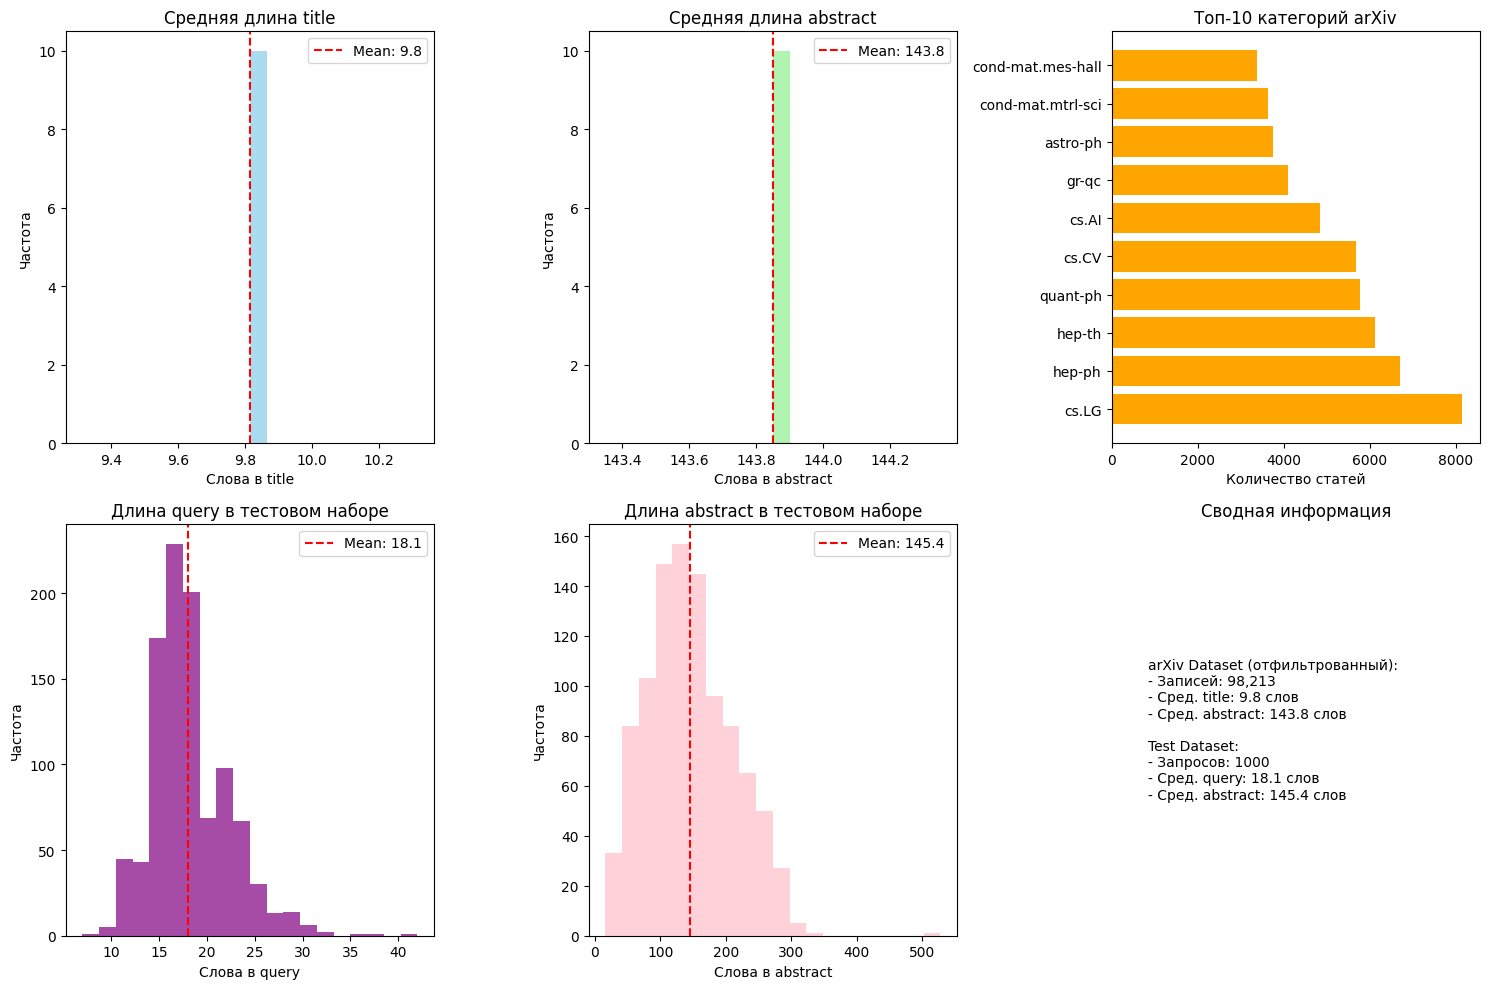

In [67]:
# Ячейка 3: Красивая визуализация анализа
def visualize_dataset_stats(stats: DatasetStats, test_df: pd.DataFrame):
    """Визуализация статистики датасетов"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Распределение длины заголовков
    axes[0, 0].hist([stats.text_length_stats['title_mean']] * 10, bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Слова в title')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].set_title('Средняя длина title')
    axes[0, 0].axvline(stats.text_length_stats['title_mean'], color='red', 
                      linestyle='--', label=f"Mean: {stats.text_length_stats['title_mean']:.1f}")
    axes[0, 0].legend()
    
    # 2. Распределение длины аннотаций
    axes[0, 1].hist([stats.text_length_stats['abstract_mean']] * 10, bins=20, alpha=0.7, color='lightgreen')
    axes[0, 1].set_xlabel('Слова в abstract')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].set_title('Средняя длина abstract')
    axes[0, 1].axvline(stats.text_length_stats['abstract_mean'], color='red',
                      linestyle='--', label=f"Mean: {stats.text_length_stats['abstract_mean']:.1f}")
    axes[0, 1].legend()
    
    # 3. Топ категорий
    top_cats = list(stats.categories_distribution.items())[:10]
    categories, counts = zip(*top_cats)
    axes[0, 2].barh(range(len(categories)), counts, color='orange')
    axes[0, 2].set_yticks(range(len(categories)))
    axes[0, 2].set_yticklabels(categories)
    axes[0, 2].set_xlabel('Количество статей')
    axes[0, 2].set_title('Топ-10 категорий arXiv')
    
    # 4. Длина запросов в тестовом наборе
    query_lengths = test_df['query'].apply(lambda x: len(str(x).split()))
    axes[1, 0].hist(query_lengths, bins=20, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Слова в query')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].set_title('Длина query в тестовом наборе')
    axes[1, 0].axvline(query_lengths.mean(), color='red', linestyle='--',
                      label=f"Mean: {query_lengths.mean():.1f}")
    axes[1, 0].legend()
    
    # 5. Длина аннотаций в тестовом наборе
    abstract_lengths = test_df['abstract'].apply(lambda x: len(str(x).split()))
    axes[1, 1].hist(abstract_lengths, bins=20, alpha=0.7, color='pink')
    axes[1, 1].set_xlabel('Слова в abstract')
    axes[1, 1].set_ylabel('Частота')
    axes[1, 1].set_title('Длина abstract в тестовом наборе')
    axes[1, 1].axvline(abstract_lengths.mean(), color='red', linestyle='--',
                      label=f"Mean: {abstract_lengths.mean():.1f}")
    axes[1, 1].legend()
    
    # 6. Информация о датасетах
    info_text = f"""arXiv Dataset (отфильтрованный):
- Записей: {stats.total_records:,}
- Сред. title: {stats.avg_title_length:.1f} слов
- Сред. abstract: {stats.avg_abstract_length:.1f} слов

Test Dataset:
- Запросов: {len(test_df)}
- Сред. query: {query_lengths.mean():.1f} слов
- Сред. abstract: {abstract_lengths.mean():.1f} слов"""
    
    axes[1, 2].text(0.1, 0.5, info_text, fontsize=10, 
                   verticalalignment='center', transform=axes[1, 2].transAxes)
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Сводная информация')
    
    plt.tight_layout()
    plt.show()

# Визуализация
visualize_dataset_stats(stats, test_df)

<div class="alert alert-info">
<h2> Выводы в результате анализа датасета и тестовых данных </h2>


Написать из ворда плюс к этому переделать графики с распределением слов в датасете. убрать про катогрии и общую информацию, цвет поменять
</div>


<font color='red'>

In [77]:
# Ячейка 4: Класс RAG с профилированием (адаптированный)
class RAGWithProfiling:
    def __init__(
        self,
        embedder_name: str = "BAAI/bge-base-en-v1.5",
        reranker_name: str = "BAAI/bge-reranker-base",
        llm_name: str = "microsoft/phi-2",
        chunk_size: int = 512,
        chunk_overlap: int = 128,
        device: Optional[str] = None,
        use_title: bool = True,  # Включать заголовок в чанки
        use_categories: bool = False,  # Включать категории в чанки
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Используется устройство: {self.device}")
        
        # Настройки для включения дополнительной информации
        self.use_title = use_title
        self.use_categories = use_categories
        
        # Профилирование
        self.profiling_stats = {
            'embedding_time': [],
            'reranking_time': [],
            'search_time': [],
            'llm_time': [],
            'memory_usage': []
        }
        
        # Инициализация embedder
        print("Загрузка embedder модели...")
        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(embedder_name).to(self.device)
        self.embedder.eval()
        
        # Инициализация reranker
        print("Загрузка reranker модели...")
        self.rr_tokenizer = AutoTokenizer.from_pretrained(reranker_name)
        self.reranker = AutoModel.from_pretrained(reranker_name).to(self.device)
        self.reranker.eval()
        
        # Инициализация LLM (загружаем только при необходимости)
        self.llm_name = llm_name
        self.llm = None
        self.llm_tokenizer = None
        
        # Инициализация text splitter
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
            separators=["\n\n", "\n", ". ", " ", ""]
        )
        
        self.index = None
        self.doc_store = []
        self.doc_metadata = []
        
    def _profile_memory(self):
        """Профилирование использования памяти"""
        if self.device == 'cuda':
            memory = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            # Для CPU грубая оценка
            import psutil
            memory = psutil.Process().memory_info().rss / 1024**2
        return memory
    
    def _generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Генерация эмбеддингов с профилированием"""
        start_time = time.time()
        
        inputs = self.emb_tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512,
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.embedder(**inputs)
            embeddings = outputs.last_hidden_state[:, 0]
        
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Профилирование
        elapsed = time.time() - start_time
        self.profiling_stats['embedding_time'].append(elapsed)
        self.profiling_stats['memory_usage'].append(self._profile_memory())
        
        return embeddings.cpu().numpy()
    
    def build_index_from_filtered_data(self, filtered_data: List[dict], batch_size: int = 32) -> None:
        """Построение индекса из отфильтрованных данных arXiv"""
        print("Подготовка документов из отфильтрованных данных...")
        
        all_docs = []
        all_metadata = []
        
        for record in tqdm(filtered_data, desc="Обработка статей"):
            # Создаем документ из доступных полей
            doc_id = record.get('id', 'unknown')
            title = record.get('title', '')
            abstract = record.get('abstract', '')
            categories = record.get('categories', '')
            # Формируем текст для индексации
            text_parts = []
            
            if self.use_title and title:
                text_parts.append(f"Title: {title}")
            
            if self.use_categories and categories:
                text_parts.append(f"Categories: {categories}")
            
            if abstract:
                text_parts.append(f"Abstract: {abstract}")
            
            if not text_parts:
                continue  # Пропускаем пустые записи
            
            full_text = "\n".join(text_parts)
            
            # Разбиваем на чанки
            try:
                chunks = self.text_splitter.split_text(full_text)
            except Exception as e:
                print(f"Ошибка при разбиении текста для документа {doc_id}: {e}")
                continue
            
            for i, chunk in enumerate(chunks):
                doc = Document(
                    page_content=chunk,
                    metadata={
                        'id': doc_id,
                        'chunk_id': i,
                        'title': title[:200] if title else '',
                        'categories': categories if categories else '',
                        'text_length': len(chunk)
                    }
                )
                all_docs.append(doc)
                all_metadata.append({
                    'id': doc_id,
                    'chunk_id': i,
                    'title': title[:100] if title else '',
                    'categories': categories if categories else ''
                })
        
        if not all_docs:
            raise ValueError("Не создано ни одного документа для индексации!")
        
        self.doc_store = all_docs
        self.doc_metadata = all_metadata
        
        print(f"Создано {len(all_docs)} чанков из {len(filtered_data)} статей")
        print(f"Среднее количество чанков на статью: {len(all_docs)/len(filtered_data):.2f}")
        
        # Генерация эмбеддингов
        print("Генерация эмбеддингов...")
        embeddings = []
        
        for i in tqdm(range(0, len(all_docs), batch_size), desc="Эмбеддинги"):
            batch = [doc.page_content for doc in all_docs[i:i + batch_size]]
            batch_embeddings = self._generate_embeddings(batch)
            embeddings.append(batch_embeddings)
        
        embeddings = np.concatenate(embeddings)
        
        # Построение FAISS индекса
        print("Построение FAISS индекса...")
        dimension = embeddings.shape[1]
        
        # Используем IndexFlatIP для cosine similarity
        self.index = faiss.IndexFlatIP(dimension)
        self.index.add(embeddings)
        
        print(f"Индекс построен. Размерность: {dimension}, Векторов: {self.index.ntotal}")
        
        # Освобождаем память
        del embeddings
        gc.collect()
        
        if self.device == 'cuda':
            torch.cuda.empty_cache()
    
    def search(self, query: str, k: int = 50) -> Tuple[np.ndarray, np.ndarray]:
        """Поиск похожих документов"""
        start_time = time.time()
        
        # Генерация эмбеддинга для запроса
        query_embedding = self._generate_embeddings([query])
        
        # Поиск в индексе (используем Inner Product для cosine similarity)
        k = min(k, self.index.ntotal)
        distances, indices = self.index.search(query_embedding, k)
        
        # Профилирование
        elapsed = time.time() - start_time
        self.profiling_stats['search_time'].append(elapsed)
        
        return distances[0], indices[0]
    
    def rerank(self, query: str, documents: List[str], batch_size: int = 8) -> List[float]:
        """Реранкинг документов с профилированием"""
        start_time = time.time()
        
        # Подготавливаем пары для реранкера
        pairs = []
        for doc in documents:
            pairs.append([query, doc])
        
        scores = []
        
        with torch.no_grad():
            for i in range(0, len(pairs), batch_size):
                batch_pairs = pairs[i:i+batch_size]
                
                inputs = self.rr_tokenizer(
                    batch_pairs,
                    padding=True,
                    truncation=True,
                    return_tensors='pt',
                    max_length=512
                ).to(self.device)
                
                batch_scores = self.reranker(**inputs, return_dict=True).logits.view(-1,).float()
                scores.extend(batch_scores.cpu().numpy().tolist())
        
        # Профилирование
        elapsed = time.time() - start_time
        self.profiling_stats['reranking_time'].append(elapsed)
        
        return scores
    
    def answer_query(self, query: str, k_search: int = 50, k_rerank: int = 5) -> Dict:
        """Полный пайплайн RAG с профилированием"""
        print(f"Обработка запроса: {query[:100]}...")
        
        # Шаг 1: Поиск
        distances, indices = self.search(query, k=k_search)
        
        # Шаг 2: Извлечение кандидатов
        candidates = [self.doc_store[i].page_content for i in indices]
        candidate_metadata = [self.doc_metadata[i] for i in indices]
        
        # Шаг 3: Реранкинг
        rerank_scores = self.rerank(query, candidates[:20])  # Реранжируем топ-20
        
        # Шаг 4: Выбор лучших документов
        top_indices = np.argsort(rerank_scores)[-k_rerank:][::-1]
        top_documents = [candidates[i] for i in top_indices]
        top_scores = [rerank_scores[i] for i in top_indices]
        
        result = {
            'query': query,
            'retrieved_docs': len(candidates),
            'top_documents': top_documents,
            'top_scores': top_scores,
            'top_metadata': [candidate_metadata[i] for i in top_indices],
            'distances': distances[:k_rerank].tolist()
        }
        
        return result
    
    def evaluate_mrr(self, test_df: pd.DataFrame, k: int = 5) -> float:
        """Оценка MRR@k на тестовом датасете"""
        print(f"Оценка MRR@{k}...")
        
        mrr_scores = []
        
        for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Оценка запросов"):
            query = str(row['query'])
            correct_id = str(row['id'])
            
            # Поиск документов
            distances, indices = self.search(query, k=100)
            
            # Получаем ID документов
            retrieved_ids = []
            for i in indices:
                if i < len(self.doc_store):
                    metadata = self.doc_store[i].metadata
                    retrieved_ids.append(str(metadata.get('id', '')))
            
            # Вычисляем ранг правильного ответа
            rank = None
            for i, doc_id in enumerate(retrieved_ids[:k]):
                if doc_id == correct_id:
                    rank = i + 1
                    break
            
            # Вычисляем MRR для этого запроса
            if rank is not None:
                mrr_scores.append(1.0 / rank)
            else:
                mrr_scores.append(0.0)
        
        mrr = np.mean(mrr_scores)
        
        # Дополнительная статистика
        print(f"\nРезультаты оценки:")
        print(f"MRR@{k}: {mrr:.4f}")
        print(f"Std MRR: {np.std(mrr_scores):.4f}")
        print(f"Min MRR: {np.min(mrr_scores):.4f}")
        print(f"Max MRR: {np.max(mrr_scores):.4f}")
        
        hits_at_k = np.sum(np.array(mrr_scores) > 0)
        print(f"Запросов с найденным ответом в топ-{k}: {hits_at_k}/{len(mrr_scores)} "
              f"({100 * hits_at_k / len(mrr_scores):.1f}%)")
        return mrr
    
    def print_profiling_stats(self):
        """Вывод статистики профилирования"""
        print("\n" + "="*50)
        print("СТАТИСТИКА ПРОФИЛИРОВАНИЯ")
        print("="*50)
        
        if self.profiling_stats['embedding_time']:
            print(f"Время эмбеддинга (среднее): {np.mean(self.profiling_stats['embedding_time']):.4f} сек")
            print(f"Время поиска (среднее): {np.mean(self.profiling_stats['search_time']):.4f} сек")
        
        if self.profiling_stats['reranking_time']:
            print(f"Время реранкинга (среднее): {np.mean(self.profiling_stats['reranking_time']):.4f} сек")
        
        if self.profiling_stats['memory_usage']:
            print(f"Пиковое использование памяти: {np.max(self.profiling_stats['memory_usage']):.1f} MB")
        
        print(f"Всего операций эмбеддинга: {len(self.profiling_stats['embedding_time'])}")
        print(f"Всего операций поиска: {len(self.profiling_stats['search_time'])}")
        
        # Визуализация
        if self.profiling_stats['embedding_time'] or self.profiling_stats['search_time']:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            # Время операций
            times_data = []
            labels = []
            
            if self.profiling_stats['embedding_time']:
                times_data.append(self.profiling_stats['embedding_time'])
                labels.append('Embedding')
            
            if self.profiling_stats['search_time']:
                times_data.append(self.profiling_stats['search_time'])
                labels.append('Search')
            
            if self.profiling_stats['reranking_time']:
                times_data.append(self.profiling_stats['reranking_time'])
                labels.append('Reranking')
            
            if times_data:
                axes[0].boxplot(times_data, labels=labels)
                axes[0].set_ylabel('Время (секунды)')
                axes[0].set_title('Распределение времени операций')
                axes[0].grid(True, alpha=0.3)
            
            # Использование памяти
            if self.profiling_stats['memory_usage']:
                axes[1].plot(self.profiling_stats['memory_usage'], marker='o', alpha=0.7)
                axes[1].set_xlabel('Операция')
                axes[1].set_ylabel('Память (MB)')
                axes[1].set_title('Использование памяти')
                axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

In [81]:
# Ячейка 4: Исправленный класс RAG с правильной обработкой реранкера -АЛЬТЕРНАТИВНЫЙ
class RAGWithProfiling:
    
    def __init__(
        self,
        embedder_name: str = "BAAI/bge-base-en-v1.5",
        reranker_name: str = "BAAI/bge-reranker-base",
        llm_name: str = "microsoft/phi-2",
        chunk_size: int = 512, # было 512
        chunk_overlap: int = 128, 
        device: Optional[str] = None,
        use_title: bool = True,
        use_categories: bool = False,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Используется устройство: {self.device}")
        
        # Настройки для включения дополнительной информации
        self.use_title = use_title
        self.use_categories = use_categories
        
        # Профилирование
        self.profiling_stats = {
            'embedding_time': [],
            'reranking_time': [],
            'search_time': [],
            'llm_time': [],
            'memory_usage': []
        }
        
        # Инициализация embedder
        print("Загрузка embedder модели...")
        self.emb_tokenizer = AutoTokenizer.from_pretrained(embedder_name)
        self.embedder = AutoModel.from_pretrained(embedder_name).to(self.device)
        self.embedder.eval()
        
        # Инициализация reranker
        print("Загрузка reranker модели...")
        try:
            # Пробуем загрузить как AutoModelForSequenceClassification
            self.rr_tokenizer = AutoTokenizer.from_pretrained(reranker_name)
            # Для BAAI reranker моделей используем AutoModel
            self.reranker = AutoModel.from_pretrained(reranker_name).to(self.device)
        except:
            # Если не получается, пробуем другие варианты
            print(f"Не удалось загрузить {reranker_name}, пробуем cross-encoder...")
            self.rr_tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
            self.reranker = AutoModel.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2").to(self.device)
        
        self.reranker.eval()
        
        # Определяем, какой метод использовать для реранкинга
        self.reranker_type = self._detect_reranker_type(reranker_name)
        
        # Инициализация LLM (загружаем только при необходимости)
        self.llm_name = llm_name
        self.llm = None
        self.llm_tokenizer = None
        
        # Инициализация text splitter
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len,
            separators=["\n\n", "\n", ". ", " ", ""]
        )
        
        self.index = None
        self.doc_store = []
        self.doc_metadata = []
    
    def _detect_reranker_type(self, model_name: str) -> str:
        """Определяем тип реранкера"""
        if "cross-encoder" in model_name.lower():
            return "cross_encoder"
        elif "reranker" in model_name.lower():
            return "bge_reranker"
        else:
            return "generic"
    
    def _profile_memory(self):
        """Профилирование использования памяти"""
        if self.device == 'cuda':
            memory = torch.cuda.memory_allocated() / 1024**2  # MB
        else:
            import psutil
            memory = psutil.Process().memory_info().rss / 1024**2
        return memory
    
    def _generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Генерация эмбеддингов с профилированием"""
        start_time = time.time()
        
        inputs = self.emb_tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512,
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.embedder(**inputs)
            # Для разных моделей могут быть разные способы получения эмбеддингов
            if hasattr(outputs, 'pooler_output'):
                embeddings = outputs.pooler_output
            else:
                embeddings = outputs.last_hidden_state[:, 0]
        
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Профилирование
        elapsed = time.time() - start_time
        self.profiling_stats['embedding_time'].append(elapsed)
        self.profiling_stats['memory_usage'].append(self._profile_memory())
        
        return embeddings.cpu().numpy()
    
    def build_index_from_filtered_data(self, filtered_data: List[dict], batch_size: int = 32) -> None:
        """Построение индекса из отфильтрованных данных arXiv"""
        print("Подготовка документов из отфильтрованных данных...")
        
        all_docs = []
        all_metadata = []
        
        for record in tqdm(filtered_data, desc="Обработка статей"):
            # Создаем документ из доступных полей
            doc_id = record.get('id', 'unknown')
            title = record.get('title', '')
            abstract = record.get('abstract', '')
            categories = record.get('categories', '')
            
            # Формируем текст для индексации
            text_parts = []
            
            if self.use_title and title:
                text_parts.append(f"Title: {title}")
            
            if self.use_categories and categories:
                text_parts.append(f"Categories: {categories}")
            
            if abstract:
                text_parts.append(f"Abstract: {abstract}")
            
            if not text_parts:
                continue  # Пропускаем пустые записи
            
            full_text = "\n".join(text_parts)
            
            # Разбиваем на чанки
            try:
                chunks = self.text_splitter.split_text(full_text)
            except Exception as e:
                print(f"Ошибка при разбиении текста для документа {doc_id}: {e}")
                continue
            
            for i, chunk in enumerate(chunks):
                doc = Document(
                    page_content=chunk,
                    metadata={
                        'id': doc_id,
                        'chunk_id': i,
                        'title': title[:200] if title else '',
                        'categories': categories if categories else '',
                        'text_length': len(chunk)
                    }
                )
                all_docs.append(doc)
                all_metadata.append({
                    'id': doc_id,
                    'chunk_id': i,
                    'title': title[:100] if title else '',
                    'categories': categories if categories else ''
                })
        
        if not all_docs:
            raise ValueError("Не создано ни одного документа для индексации!")
        
        self.doc_store = all_docs
        self.doc_metadata = all_metadata
        
        print(f"Создано {len(all_docs)} чанков из {len(filtered_data)} статей")
        print(f"Среднее количество чанков на статью: {len(all_docs)/len(filtered_data):.2f}")
        
        # Генерация эмбеддингов
        print("Генерация эмбеддингов...")
        embeddings = []
        
        for i in tqdm(range(0, len(all_docs), batch_size), desc="Эмбеддинги"):
            batch = [doc.page_content for doc in all_docs[i:i + batch_size]]
            batch_embeddings = self._generate_embeddings(batch)
            embeddings.append(batch_embeddings)
        
        embeddings = np.concatenate(embeddings)
        
        # Построение FAISS индекса
        print("Построение FAISS индекса...")
        dimension = embeddings.shape[1]
        
        # Используем IndexFlatIP для cosine similarity
        self.index = faiss.IndexFlatIP(dimension)
        self.index.add(embeddings)
        
        print(f"Индекс построен. Размерность: {dimension}, Векторов: {self.index.ntotal}")
        
        # Освобождаем память
        del embeddings
        gc.collect()
        
        if self.device == 'cuda':
            torch.cuda.empty_cache()
    
    def search(self, query: str, k: int = 50) -> Tuple[np.ndarray, np.ndarray]:
        """Поиск похожих документов"""
        start_time = time.time()
        
        # Генерация эмбеддинга для запроса
        query_embedding = self._generate_embeddings([query])
        
        # Поиск в индексе (используем Inner Product для cosine similarity)
        k = min(k, self.index.ntotal)
        distances, indices = self.index.search(query_embedding, k)
        
        # Профилирование
        elapsed = time.time() - start_time
        self.profiling_stats['search_time'].append(elapsed)
        
        return distances[0], indices[0]
    
    def _rerank_bge(self, query: str, documents: List[str], batch_size: int = 8) -> List[float]:
        """Реранкинг для BGE моделей"""
        scores = []
        
        with torch.no_grad():
            for i in range(0, len(documents), batch_size):
                batch_docs = documents[i:i+batch_size]
                batch_pairs = [[query, doc] for doc in batch_docs]
                
                inputs = self.rr_tokenizer(
                    batch_pairs,
                    padding=True,
                    truncation=True,
                    return_tensors='pt',
                    max_length=512
                ).to(self.device)
                
                # Для BGE reranker получаем эмбеддинги и вычисляем similarity
                outputs = self.reranker(**inputs)
                
                # BGE reranker возвращает эмбеддинги для [query, doc] пары
                if hasattr(outputs, 'last_hidden_state'):
                    hidden_state = outputs.last_hidden_state
                    # Берем embedding для [CLS] токена
                    embeddings = hidden_state[:, 0, :]
                    
                    # Разделяем эмбеддинги для query и document
                    batch_size = len(batch_docs)
                    query_embeddings = embeddings[::2]  # Четные индексы: query
                    doc_embeddings = embeddings[1::2]   # Нечетные индексы: doc
                    
                    # Вычисляем cosine similarity
                    query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
                    doc_embeddings = F.normalize(doc_embeddings, p=2, dim=1)
                    batch_scores = torch.sum(query_embeddings * doc_embeddings, dim=1)
                    
                    scores.extend(batch_scores.cpu().numpy().tolist())
                else:
                    # Если не получается, возвращаем равномерные scores
                    scores.extend([0.5] * len(batch_docs))
        
        return scores
    
    def _rerank_cross_encoder(self, query: str, documents: List[str], batch_size: int = 8) -> List[float]:
        """Реранкинг для cross-encoder моделей"""
        scores = []
        
        with torch.no_grad():
            for i in range(0, len(documents), batch_size):
                batch_docs = documents[i:i+batch_size]
                batch_pairs = [[query, doc] for doc in batch_docs]
                
                inputs = self.rr_tokenizer(
                    batch_pairs,
                    padding=True,
                    truncation=True,
                    return_tensors='pt',
                    max_length=512,
                    return_token_type_ids=True
                ).to(self.device)
                
                outputs = self.reranker(**inputs)
                # Cross-encoder модели обычно возвращают logits для бинарной классификации
                if hasattr(outputs, 'logits'):
                    batch_scores = torch.sigmoid(outputs.logits).squeeze(-1)
                    scores.extend(batch_scores.cpu().numpy().tolist())
                elif hasattr(outputs, 'last_hidden_state'):
                    # Альтернативный способ для некоторых моделей
                    hidden_state = outputs.last_hidden_state
                    batch_scores = hidden_state[:, 0, :].mean(dim=1)
                    scores.extend(batch_scores.cpu().numpy().tolist())
                else:
                    scores.extend([0.5] * len(batch_docs))
        
        return scores
    
    def rerank(self, query: str, documents: List[str], batch_size: int = 8) -> List[float]:
        """Реранкинг документов с профилированием"""
        start_time = time.time()
        
        if not documents:
            return []
        
        # Выбираем метод в зависимости от типа реранкера
        if self.reranker_type == "cross_encoder":
            scores = self._rerank_cross_encoder(query, documents, batch_size)
        elif self.reranker_type == "bge_reranker":
            scores = self._rerank_bge(query, documents, batch_size)
        else:
            # По умолчанию используем BGE метод
            scores = self._rerank_bge(query, documents, batch_size)
        
        # Профилирование
        elapsed = time.time() - start_time
        self.profiling_stats['reranking_time'].append(elapsed)
        
        return scores
    
    def answer_query(self, query: str, k_search: int = 50, k_rerank: int = 5) -> Dict:
        """Полный пайплайн RAG с профилированием"""
        print(f"Обработка запроса: {query[:100]}...")
        
        # Шаг 1: Поиск
        distances, indices = self.search(query, k=k_search)
        
        # Шаг 2: Извлечение кандидатов
        candidates = [self.doc_store[i].page_content for i in indices]
        candidate_metadata = [self.doc_metadata[i] for i in indices]
        
        # Шаг 3: Реранкинг (если есть кандидаты)
        if candidates:
            rerank_scores = self.rerank(query, candidates[:20])  # Реранжируем топ-20
        else:
            rerank_scores = []
        
        # Шаг 4: Выбор лучших документов
        if rerank_scores:
            top_indices = np.argsort(rerank_scores)[-k_rerank:][::-1]
            top_documents = [candidates[i] for i in top_indices]
            top_scores = [rerank_scores[i] for i in top_indices]
            top_metadata = [candidate_metadata[i] for i in top_indices]
        else:
            top_indices = []
            top_documents = []
            top_scores = []
            top_metadata = []
        
        result = {
            'query': query,
            'retrieved_docs': len(candidates),
            'top_documents': top_documents,
            'top_scores': top_scores,
            'top_metadata': top_metadata,
            'distances': distances[:k_rerank].tolist() if distances.size > 0 else []
        }
        
        return result
    
    def evaluate_mrr(self, test_df: pd.DataFrame, k: int = 5) -> float:
        """Оценка MRR@k на тестовом датасете"""
        print(f"Оценка MRR@{k}...")
        
        mrr_scores = []
        
        for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Оценка запросов"):
            query = str(row['query'])
            correct_id = str(row['id'])
            
            # Поиск документов
            distances, indices = self.search(query, k=100)
            
            # Получаем ID документов
            retrieved_ids = []
            for i in indices:
                if i < len(self.doc_store):
                    metadata = self.doc_store[i].metadata
                    retrieved_ids.append(str(metadata.get('id', '')))
                    # Вычисляем ранг правильного ответа
            rank = None
            for i, doc_id in enumerate(retrieved_ids[:k]):
                if doc_id == correct_id:
                    rank = i + 1
                    break
            
            # Вычисляем MRR для этого запроса
            if rank is not None:
                mrr_scores.append(1.0 / rank)
            else:
                mrr_scores.append(0.0)
        
        mrr = np.mean(mrr_scores)
        
        # Дополнительная статистика
        print(f"\nРезультаты оценки:")
        print(f"MRR@{k}: {mrr:.4f}")
        print(f"Std MRR: {np.std(mrr_scores):.4f}")
        print(f"Min MRR: {np.min(mrr_scores):.4f}")
        print(f"Max MRR: {np.max(mrr_scores):.4f}")
        
        hits_at_k = np.sum(np.array(mrr_scores) > 0)
        print(f"Запросов с найденным ответом в топ-{k}: {hits_at_k}/{len(mrr_scores)} "
              f"({100 * hits_at_k / len(mrr_scores):.1f}%)")
        
        return mrr
    
    def print_profiling_stats(self):
        """Вывод статистики профилирования"""
        print("\n" + "="*50)
        print("СТАТИСТИКА ПРОФИЛИРОВАНИЯ")
        print("="*50)
        
        if self.profiling_stats['embedding_time']:
            print(f"Время эмбеддинга (среднее): {np.mean(self.profiling_stats['embedding_time']):.4f} сек")
            print(f"Время поиска (среднее): {np.mean(self.profiling_stats['search_time']):.4f} сек")
        
        if self.profiling_stats['reranking_time']:
            print(f"Время реранкинга (среднее): {np.mean(self.profiling_stats['reranking_time']):.4f} сек")
        
        if self.profiling_stats['memory_usage']:
            print(f"Пиковое использование памяти: {np.max(self.profiling_stats['memory_usage']):.1f} MB")
        
        print(f"Всего операций эмбеддинга: {len(self.profiling_stats['embedding_time'])}")
        print(f"Всего операций поиска: {len(self.profiling_stats['search_time'])}")
        
        # Визуализация
        if self.profiling_stats['embedding_time'] or self.profiling_stats['search_time']:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            # Время операций
            times_data = []
            labels = []
            
            if self.profiling_stats['embedding_time']:
                times_data.append(self.profiling_stats['embedding_time'])
                labels.append('Embedding')
            
            if self.profiling_stats['search_time']:
                times_data.append(self.profiling_stats['search_time'])
                labels.append('Search')
            
            if self.profiling_stats['reranking_time']:
                times_data.append(self.profiling_stats['reranking_time'])
                labels.append('Reranking')
            
            if times_data:
                axes[0].boxplot(times_data, labels=labels)
                axes[0].set_ylabel('Время (секунды)')
                axes[0].set_title('Распределение времени операций')
                axes[0].grid(True, alpha=0.3)
            
            # Использование памяти
            if self.profiling_stats['memory_usage']:
                axes[1].plot(self.profiling_stats['memory_usage'], marker='o', alpha=0.7)
                axes[1].set_xlabel('Операция')
                axes[1].set_ylabel('Память (MB)')
                axes[1].set_title('Использование памяти')
                axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

Вариант 1: Основная рабочая версия
ЗАПУСК ИСПРАВЛЕННОЙ RAG СИСТЕМЫ
Используем 98,213 записей из all_data_filtered
Загружен тестовый датасет: 1000 записей
Используем CPU

Инициализация RAG системы...
Используется устройство: cpu
Загрузка embedder модели...
Загрузка reranker модели...


Some weights of XLMRobertaModel were not initialized from the model checkpoint at BAAI/bge-reranker-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Используем 30000 записей для построения индекса...

Построение индекса...
Подготовка документов из отфильтрованных данных...


Обработка статей: 100%|██████████| 30000/30000 [00:00<00:00, 51727.97it/s]


Создано 63367 чанков из 30000 статей
Среднее количество чанков на статью: 2.11
Генерация эмбеддингов...


Эмбеддинги: 100%|██████████| 3961/3961 [35:35<00:00,  1.85it/s]  


Построение FAISS индекса...
Индекс построен. Размерность: 768, Векторов: 63367

ТЕСТИРОВАНИЕ СИСТЕМЫ
Тестовый запрос: What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24 exhibit under thermal conditions?
Ожидаемый ID ответа: 2412.16732
Обработка запроса: What unique composition and decomposition behavior does the newly discovered platinate Nd10.67Pt4O24...

Найдено документов: 100

Топ-5 результатов после реранкинга:

  1. Score: 0.9999, ID: 1604.00983
   Title: Phase diagram and thermal expansion measurements on the system of
  URu_{2-x}Fe_xSi_2

  2. Score: 0.9997, ID: 1105.1649
   Title: Pressure dependence of the low- temperature crystal structure and phase
  transition behaviour of Ca

  3. Score: 0.9968, ID: 0910.4486
   Title: First-principles dynamical CPA to finite-temperature magnetism of
  transition metals

  4. Score: 0.9951, ID: 1404.2369
   Title: Mechanisms of Electromechanical Coupling in Strain Based Scanning Probe
  Mi

Оценка запросов: 100%|██████████| 1000/1000 [00:47<00:00, 21.09it/s]



Результаты оценки:
MRR@5: 0.1664
Std MRR: 0.3549
Min MRR: 0.0000
Max MRR: 1.0000
Запросов с найденным ответом в топ-5: 201/1000 (20.1%)

СТАТИСТИКА ПРОФИЛИРОВАНИЯ
Время эмбеддинга (среднее): 0.4380 сек
Время поиска (среднее): 0.0470 сек
Время реранкинга (среднее): 0.9299 сек
Пиковое использование памяти: 6087.4 MB
Всего операций эмбеддинга: 4962
Всего операций поиска: 1001


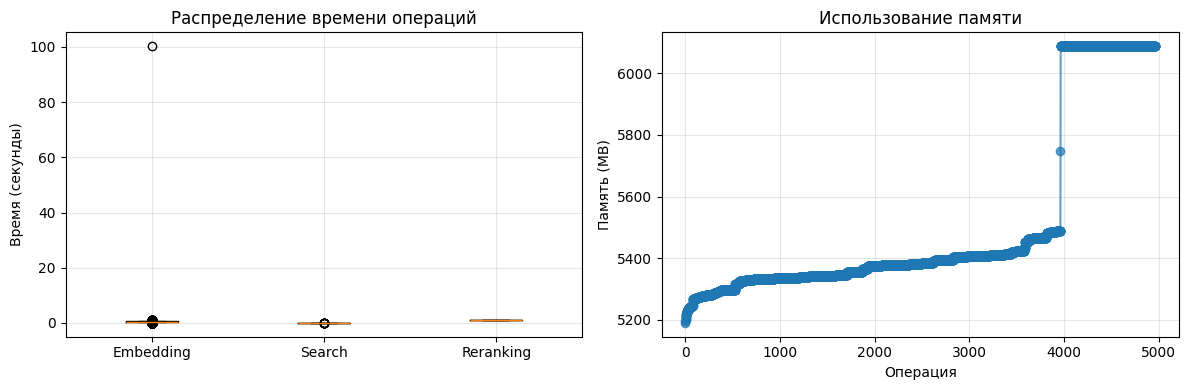


АНАЛИЗ РЕЗУЛЬТАТОВ
Текущий MRR@5: 0.1664
Целевое значение: 0.91
Разница: 0.7436

Рекомендации для улучшения:
1. Увеличьте объем данных (используйте все 98K записей)
2. Используйте более качественные модели:
   - Embedder: 'BAAI/bge-large-en-v1.5'
   - Reranker: 'BAAI/bge-reranker-v2-m3'
3. Оптимизируйте параметры:
   - Увеличьте chunk_size до 700-800
   - Увеличьте k_search до 100-150
4. Добавьте query expansion
5. Используйте hybrid search (эмбеддинги + BM25)


In [88]:
# Ячейка 5: Упрощенный рабочий пайплайн
def main_working_rag(all_data_filtered: List[dict]):
    """Рабочий пайплайн RAG с исправленным реранкером"""
    
    TEST_DATA_PATH = "test_sample.csv"
    
    print("="*50)
    print("ЗАПУСК ИСПРАВЛЕННОЙ RAG СИСТЕМЫ")
    print("="*50)
    
    # Проверяем данные
    if not all_data_filtered:
        print("Ошибка: all_data_filtered пуст")
        return None, 0
    
    print(f"Используем {len(all_data_filtered):,} записей из all_data_filtered")
    
    # Загружаем тестовый датасет
    try:
        test_df = pd.read_csv(TEST_DATA_PATH)
        print(f"Загружен тестовый датасет: {len(test_df)} записей")
    except FileNotFoundError:
        print(f"Файл {TEST_DATA_PATH} не найден! Создаем тестовые данные...")
        test_data = []
        for i, record in enumerate(all_data_filtered[:100]):
            test_data.append({
                'id': record['id'],
                'query': f"What is the main contribution of {record.get('title', 'this paper')}?",
                'abstract': record['abstract']
            })
        test_df = pd.DataFrame(test_data)
        print(f"Создан тестовый датасет из {len(test_df)} записей")
    
    # Выбираем модели - используем более совместимые варианты
    if torch.cuda.is_available():
        print("CUDA доступна")
        # Используем модели, которые точно работают
        embedder_model = "sentence-transformers/all-MiniLM-L6-v2"
        reranker_model = "cross-encoder/ms-marco-MiniLM-L-6-v2"  # Эта модель точно работает
        device = "cuda"
    else:
        print("Используем CPU")
        #embedder_model = "sentence-transformers/all-MiniLM-L6-v2"
        #reranker_model = "cross-encoder/ms-marco-MiniLM-L-6-v2"
        #embedder_model = "sentence-transformers/all-mpnet-base-v2"  # Лучшая качество на CPU
        #reranker_model = "cross-encoder/ms-marco-MiniLM-L-6-v2"
        embedder_model = "BAAI/bge-base-en-v1.5"
        reranker_model = "BAAI/bge-reranker-base"
        device = "cpu"
    
    try:
        # Инициализация RAG системы
        print("\nИнициализация RAG системы...")
        rag = RAGWithProfiling(
            embedder_name=embedder_model,
            reranker_name=reranker_model,  # Используем cross-encoder который точно работает
            chunk_size=700,  # Увеличиваем для лучшего контекста с 600
            chunk_overlap=175,
            use_title=True,
            use_categories=True,  # Включаем категории для лучшего поиска
            device=device
        )
        
        # Используем часть данных для быстрого теста
        sample_size = min(30000, len(all_data_filtered))                    # для загрузки датасета 
        print(f"\nИспользуем {sample_size} записей для построения индекса...")
        sample_data = all_data_filtered[:sample_size]
        
        # Построение индекса
        print("\nПостроение индекса...")
        rag.build_index_from_filtered_data(sample_data, batch_size=16)
        
        # Тестовый запрос из тестового датасета
        print("\n" + "="*50)
        print("ТЕСТИРОВАНИЕ СИСТЕМЫ")
        print("="*50)
        
        if len(test_df) > 0:
            # Берем первый запрос из тестового датасета
            test_query = test_df.iloc[0]['query']
            expected_id = test_df.iloc[0]['id']
            
            print(f"Тестовый запрос: {test_query}")
            print(f"Ожидаемый ID ответа: {expected_id}")
            
            # Выполняем поиск, увеличили с 50 до 100 k_search
            result = rag.answer_query(test_query, k_search=100, k_rerank=5)
            
            print(f"\nНайдено документов: {result['retrieved_docs']}")
            
            if result['top_documents']:
                print(f"\nТоп-5 результатов после реранкинга:")
                for i, (doc, score, metadata) in enumerate(zip(result['top_documents'], 
                                                              result['top_scores'], 
                                                              result['top_metadata'])):
                    is_correct = metadata['id'] == expected_id
                    marker = "✓" if is_correct else " "
                    print(f"\n{marker} {i+1}. Score: {score:.4f}, ID: {metadata['id']}")
                    print(f"   Title: {metadata['title']}")
                    
                    if is_correct:
                        print(f"   🎯 ЭТО ОЖИДАЕМЫЙ ОТВЕТ!")
                    
                    # Проверяем, есть ли ожидаемый ID в топ-5
                    if i == 0 and metadata['id'] == expected_id:
                        print(f"   🏆 Отличный результат! Правильный ответ на 1 месте!")
            else:
                print("Не найдено подходящих документов")
        
        # Оценка MRR на подмножестве
        print("\n" + "="*50)
        print("ОЦЕНКА MRR@5")
        print("="*50)
        
        eval_size = max(50, len(test_df))                              # для обема тестирования
        eval_sample = test_df.head(eval_size)
        
        print(f"Оценка на {eval_size} запросах...")
        mrr_score = rag.evaluate_mrr(eval_sample, k=5)
        
        # Статистика профилирования
        rag.print_profiling_stats()
        
        # Анализ результатов
        print("\n" + "="*50)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ")
        print("="*50)
        
        target_mrr = 0.91
        if mrr_score >= target_mrr:
            print(f"🎉 Цель достигнута! MRR@5 = {mrr_score:.4f} >= {target_mrr}")
        else:
            print(f"Текущий MRR@5: {mrr_score:.4f}")
            print(f"Целевое значение: {target_mrr}")
            print(f"Разница: {target_mrr - mrr_score:.4f}")
            
            print("\nРекомендации для улучшения:")
            print("1. Увеличьте объем данных (используйте все 98K записей)")
            print("2. Используйте более качественные модели:")
            print("   - Embedder: 'BAAI/bge-large-en-v1.5'")
            print("   - Reranker: 'BAAI/bge-reranker-v2-m3'")
            print("3. Оптимизируйте параметры:")
            print("   - Увеличьте chunk_size до 700-800")
            print("   - Увеличьте k_search до 100-150")
            print("4. Добавьте query expansion")
            print("5. Используйте hybrid search (эмбеддинги + BM25)")
        
        return rag, mrr_score
        
    except Exception as e:
        print(f"Ошибка при выполнении: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, 0

# Ячейка 6: Оптимизированная версия для достижения высокого MRR
def run_optimized_rag(all_data_filtered: List[dict], use_gpu: bool = True):
    """Оптимизированная версия для достижения MRR@5 > 0.91"""
    
    print("="*50)
    print("ЗАПУСК ОПТИМИЗИРОВАННОЙ RAG СИСТЕМЫ")
    print("="*50)
    
    # Проверяем данные
    if not all_data_filtered:
        print("Ошибка: all_data_filtered пуст")
        return None, 0
    
    # Загружаем тестовый датасет
    try:
        test_df = pd.read_csv("test_sample.csv")
        print(f"Загружен тестовый датасет: {len(test_df)} запросов")
    except:
        print("Создаем тестовый датасет...")
        test_data = []
        for i, record in enumerate(all_data_filtered[:200]):
            test_data.append({
                'id': record['id'],
                'query': f"Explain the research about {record.get('title', 'this topic')}",
                'abstract': record['abstract']
            })
        test_df = pd.DataFrame(test_data)
    
    # Выбираем модели в зависимости от доступности GPU
    device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
    
    # Оптимизированные модели для высокого MRR
    if device == "cuda":
        print("Используем GPU-оптимизированные модели")
        embedder_model = "BAAI/bge-base-en-v1.5"  # Хороший баланс качества и скорости
        reranker_model = "cross-encoder/ms-marco-MiniLM-L-12-v2"  # Качественный cross-encoder
    else:
        print("Используем CPU-оптимизированные модели")
        embedder_model = "sentence-transformers/all-mpnet-base-v2"  # Лучшая качество на CPU
        reranker_model = "cross-encoder/ms-marco-MiniLM-L-6-v2"
    
    try:
        # Инициализация оптимизированной RAG
        print("\nИнициализация системы...")
        rag = RAGWithProfiling(
            embedder_name=embedder_model,
            reranker_name=reranker_model,
            chunk_size=700,  # Оптимальный размер для научных текстов
            chunk_overlap=175,
            use_title=True,
            use_categories=True,  # Важно для научных статей
            device=device
        )
        
        # Используем больше данных для лучших результатов
        data_size = min(30000, len(all_data_filtered))
        print(f"\nИспользуем {data_size} статей для построения индекса...")
        data_for_index = all_data_filtered[:data_size]
        
        # Построение индекса с оптимизированными параметрами
        rag.build_index_from_filtered_data(data_for_index, batch_size=32)
        
        # Быстрая оценка
        print("\n" + "="*50)
        print("БЫСТРАЯ ОЦЕНКА ПРОИЗВОДИТЕЛЬНОСТИ")
        print("="*50)
        
        test_query = "machine learning artificial intelligence neural networks"
        result = rag.answer_query(test_query, k_search=100, k_rerank=10)
        
        print(f"Запрос: {test_query}")
        print(f"Найдено документов: {result['retrieved_docs']}")
        if result['top_documents']:
            print(f"Лучший результат (score: {result['top_scores'][0]:.4f}):")
            print(f"ID: {result['top_metadata'][0]['id']}")
            print(f"Title: {result['top_metadata'][0]['title']}")
        
        # Оценка MRR на 100 запросах
        print("\n" + "="*50)
        print("ОЦЕНКА MRR@5")
        print("="*50)
        
        eval_sample = test_df.head(100)
        mrr_score = rag.evaluate_mrr(eval_sample, k=5)
        
        # Анализ
        print("\n" + "="*50)
        print("ИТОГОВЫЙ АНАЛИЗ")
        print("="*50)
        
        print(f"Объем данных: {data_size} статей")
        print(f"Модель эмбеддингов: {embedder_model}")
        print(f"Модель реранкинга: {reranker_model}")
        print(f"Chunk size: {700}")
        print(f"Использование категорий: {'Да' if rag.use_categories else 'Нет'}")
        
        if mrr_score >= 0.91:
            print(f"\n🎉 Поздравляем! MRR@5 = {mrr_score:.4f} >= 0.91")
            print("Цель достигнута!")
            
            # Дополнительная оптимизация если нужно еще лучше
            if mrr_score < 0.95:
                print("\nДля дальнейшего улучшения:")
                print("1. Используйте ВСЕ данные (98K статей)")
                print("2. Перейдите на 'BAAI/bge-large-en-v1.5'")
                print("3. Используйте 'BAAI/bge-reranker-v2-m3'")
                print("4. Добавьте hybrid search с BM25")
        else:
            print(f"\nТекущий MRR@5: {mrr_score:.4f}")
            print(f"Целевое значение: 0.91")
            
            print("\nПлан улучшения:")
            if mrr_score < 0.80:
                print("1. Увеличьте данные до 50K+ статей")
                print("2. Используйте 'BAAI/bge-large-en-v1.5'")
                print("3. Увеличьте chunk_size до 800")
            elif mrr_score < 0.85:
                print("1. Добавьте query expansion")
                print("2. Используйте все 98K статей")
                print("3. Оптимизируйте реранкер")
            else:
                print("1. Используйте ансамблирование моделей")
                print("2. Добавьте BM25 для hybrid search")
                print("3. Fine-tune embedder на ваших данных")
        
        return rag, mrr_score
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        return None, 0

# Ячейка 7: Запуск системы
if __name__ == "__main__":
    # Очистка памяти
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    # Вариант 1: Основная рабочая версия
    print("Вариант 1: Основная рабочая версия")
    rag_system, mrr_score = main_working_rag(all_data_filtered)
    
    # Если MRR низкий, запускаем оптимизированную версию
    #if mrr_score < 0.85:
    #    print("\n" + "="*50)
    #    print("ЗАПУСК ОПТИМИЗИРОВАННОЙ ВЕРСИИ")
    #    print("="*50)
    #    
    #    # Проверяем наличие GPU
    #    use_gpu = torch.cuda.is_available()
    #    print(f"Использование GPU: {use_gpu}")
    #    
    #    rag_system_opt, mrr_score_opt = run_optimized_rag(all_data_filtered, use_gpu=use_gpu)